In [2]:
import sys
from pathlib import Path

sys.path.append(str(Path("../..").resolve()))

from src.data_ingestion import *
from src.data_preprocessing import *
from src.descriptive_analytics import *

from pyspark.sql import DataFrame
from pyspark.sql.functions import col
from pyspark.sql.types import NumericType, StringType
from pyspark.sql import functions as F

import seaborn as sns

import numpy as np

from itertools import combinations

from scipy import stats

import matplotlib.pyplot as plt

import pandas as pd
from pyspark.sql.window import Window




In [3]:
spark = init_spark()
df = load_data(spark, "../../data/US_Accidents_March23.csv")

### Location Analysis

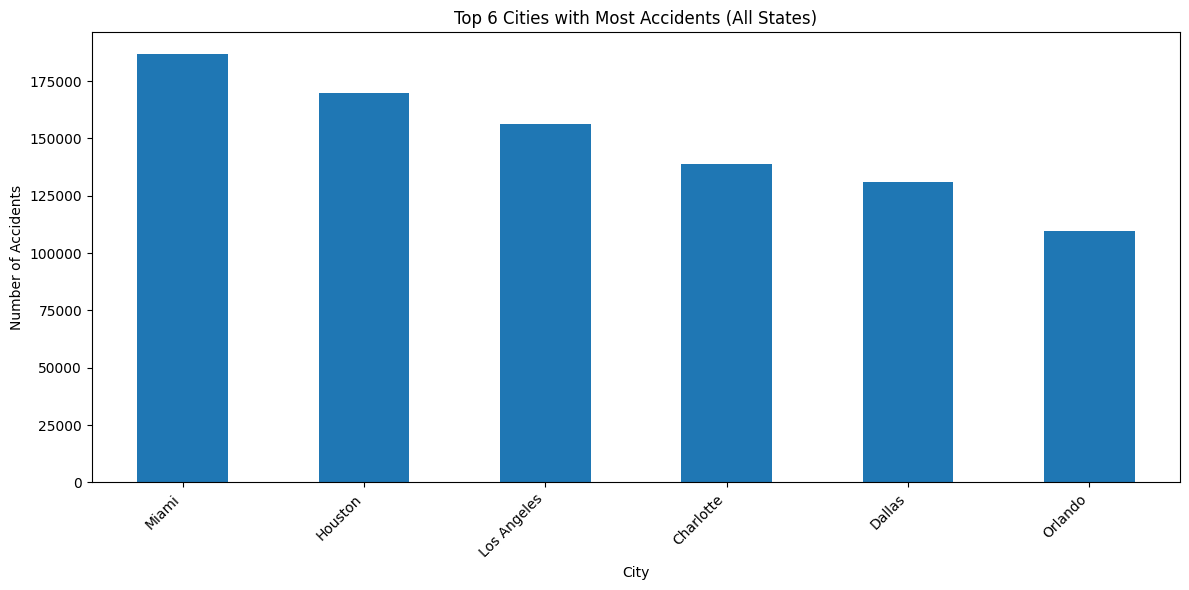

In [4]:
# Group by City and count accidents
count_cities = 6
top_cities = df.groupBy("City").count().orderBy("count", ascending=False).limit(count_cities)

# Convert to Pandas for plotting
top_cities_pd = top_cities.toPandas()


plt.figure(figsize=(12, 6))
top_cities_pd.set_index("City")["count"].plot(kind="bar")
plt.title('Top ' + str(count_cities) + ' Cities with Most Accidents (All States)')
plt.xlabel('City')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Top 2 cities for severity 1:
        City  count
0     Tucson   3229
1  Charlotte   2526
Top 2 cities for severity 2:
      City   count
2    Miami  169909
3  Houston  138459
Top 2 cities for severity 3:
          City  count
4  Los Angeles  34927
5       Dallas  33024
Top 2 cities for severity 4:
      City  count
6  Atlanta   2841
7    Miami   2192


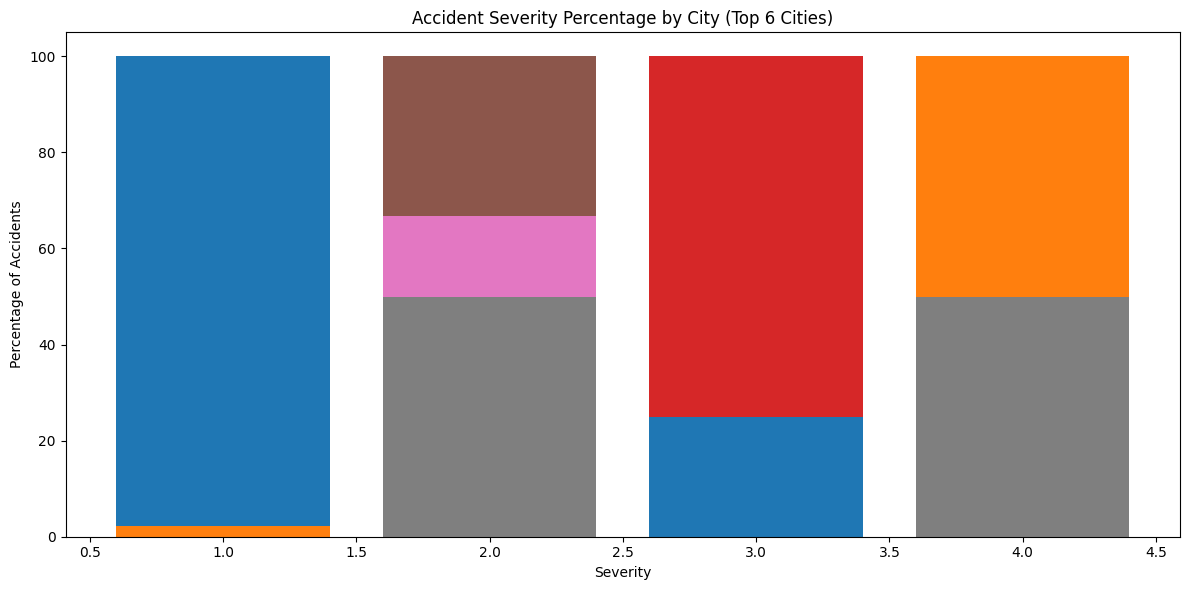

In [5]:

count_cities = 6
city_severity_counts = df.groupBy("City", "Severity").count()

city_totals = city_severity_counts.groupBy("City").agg(F.sum("count").alias("total_accidents"))

city_severity_percentages = city_severity_counts.join(city_totals, on="City") \
    .withColumn("percentage", (city_severity_counts["count"] / city_totals["total_accidents"]) * 100)

city_severity_percentages_pd = city_severity_percentages.toPandas()

top_2_cities_per_severity = city_severity_counts.withColumn("rank", F.row_number().over(
    Window.partitionBy("Severity").orderBy(F.desc("count")))) \
    .filter(F.col("rank") <= 2) \
    .drop("rank")

top_2_cities_per_severity_pd = top_2_cities_per_severity.toPandas()

plt.figure(figsize=(12, 6))

for city in city_severity_percentages_pd["City"].unique():
    city_data = city_severity_percentages_pd[city_severity_percentages_pd["City"] == city]
    plt.bar(city_data["Severity"], city_data["percentage"])

plt.title('Accident Severity Percentage by City (Top ' + str(count_cities) + ' Cities)')
plt.xlabel('Severity')
plt.ylabel('Percentage of Accidents')

for severity in top_2_cities_per_severity_pd["Severity"].unique():
    top_cities = top_2_cities_per_severity_pd[top_2_cities_per_severity_pd["Severity"] == severity]
    print(f"Top 2 cities for severity {severity}:")
    print(top_cities[['City', 'count']])

plt.tight_layout()
plt.show()

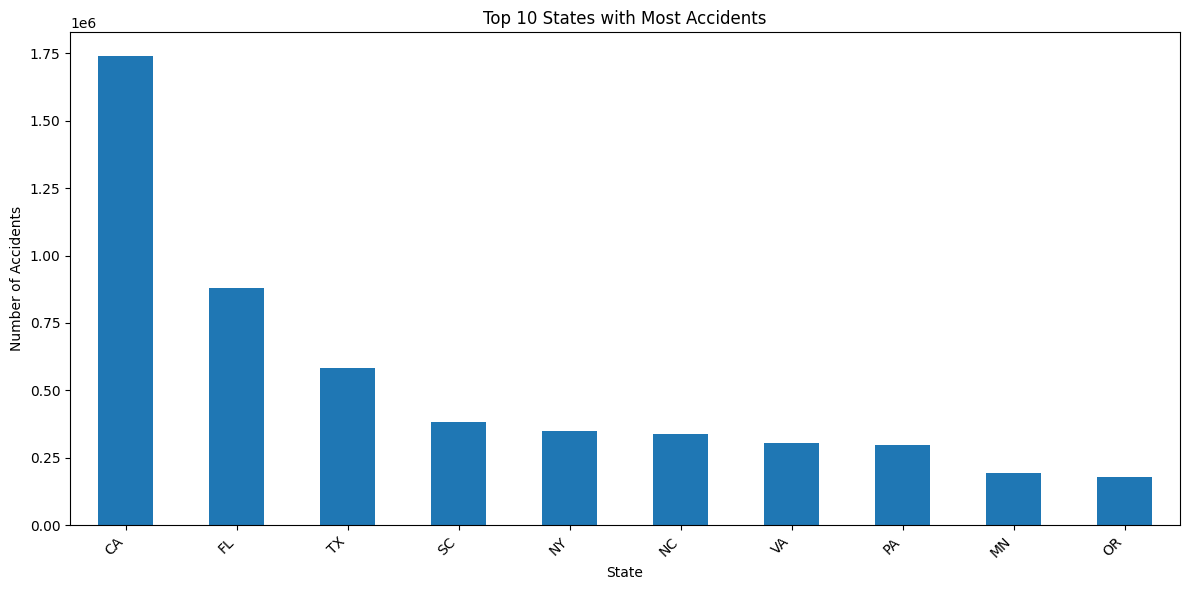

,State,count
0,CA,1741433
1,FL,880192
2,TX,582837
3,SC,382557
4,NY,347960
5,NC,338199
6,VA,303301
7,PA,296620
8,MN,192084
9,OR,179660


In [6]:
top_n_states = 10
state_counts = df.groupBy("State").count().orderBy("count", ascending=False).limit(top_n_states)

# Convert to Pandas for plotting
state_counts_pd = state_counts.toPandas()

# Plot
plt.figure(figsize=(12, 6))
state_counts_pd.set_index("State")["count"].plot(kind="bar")
plt.title(f'Top {top_n_states} States with Most Accidents')
plt.xlabel('State')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Display the DataFrame
state_counts_pd

<Figure size 1500x1000 with 0 Axes>

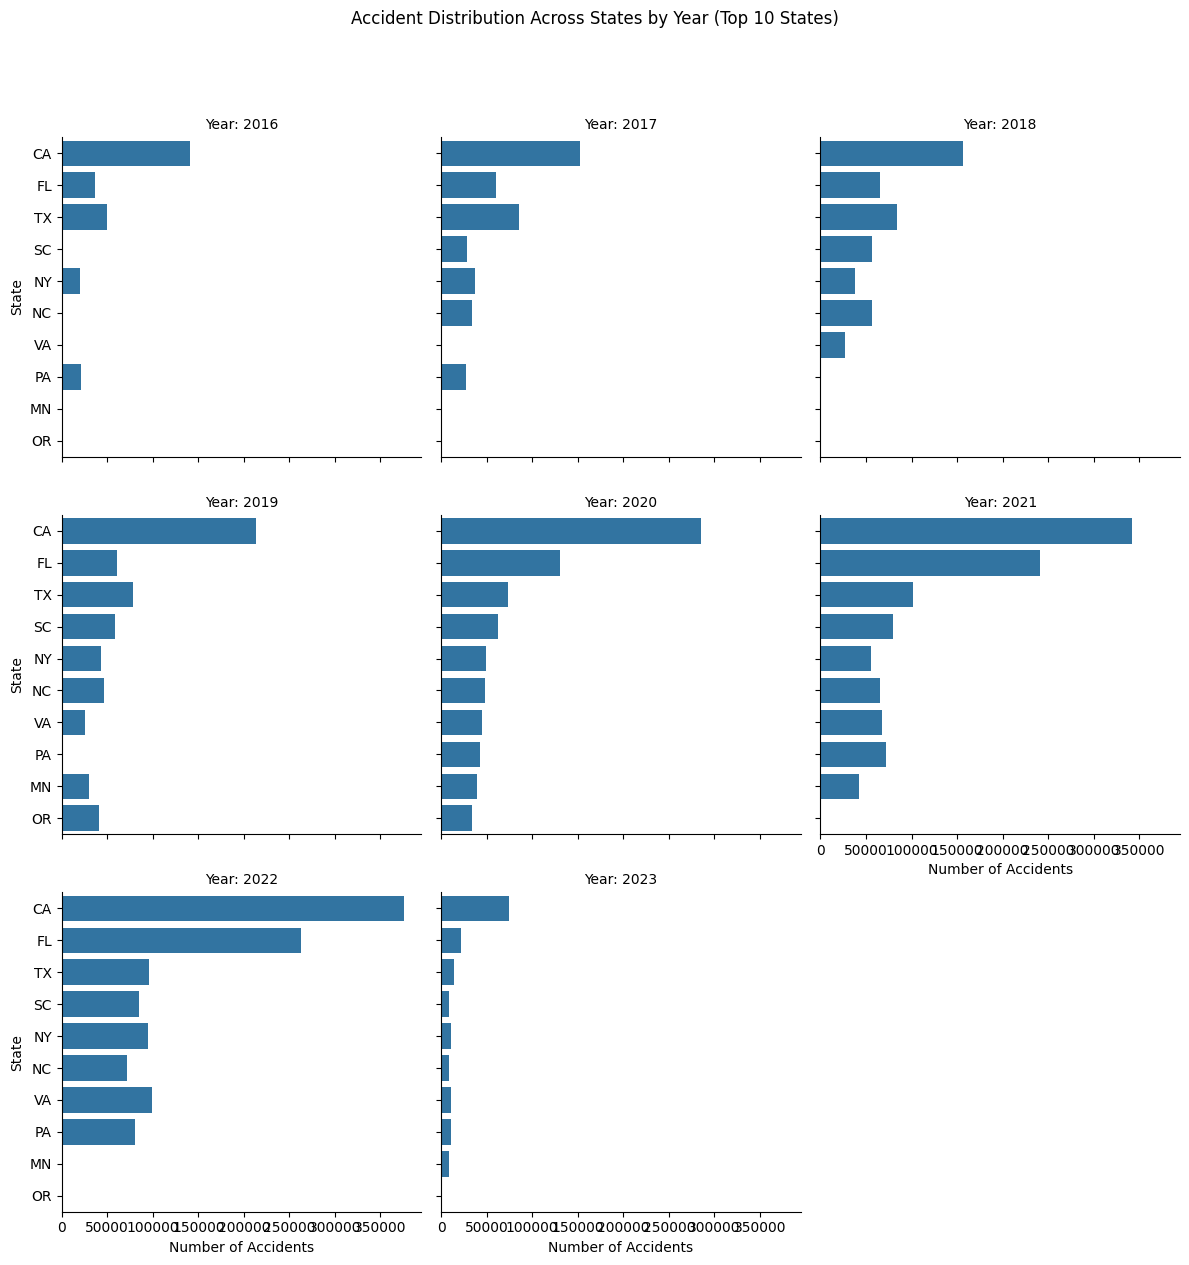

,Year,State,count
0,2016,CA,140452
1,2016,TX,49769
2,2016,FL,37060
3,2016,PA,21232
4,2016,NY,20097
...,...,...,...
75,2023,PA,10605
76,2023,NC,9133
77,2023,MN,8949
78,2023,SC,8534


In [8]:
df_with_year = df.withColumn("Year", F.year("Start_Time"))

# Group by Year and State, count accidents, and get top 10 states per year
top_n_states = 10
state_year_counts = df_with_year.groupBy("Year", "State").count()
state_year_counts = state_year_counts.withColumn(
    "rank", 
    F.row_number().over(Window.partitionBy("Year").orderBy(F.desc("count")))
).filter(F.col("rank") <= top_n_states).drop("rank")

# Convert to Pandas for plotting
state_year_counts_pd = state_year_counts.toPandas()

# Sort years for consistent plotting
years = sorted(state_year_counts_pd["Year"].unique())

# Plot: Distribution of accidents across states for each year
plt.figure(figsize=(15, 10))
g = sns.FacetGrid(state_year_counts_pd, col="Year", col_wrap=3, height=4, sharey=True)
g.map(sns.barplot, "count", "State", order=state_year_counts_pd.groupby("State")["count"].sum().nlargest(top_n_states).index)
g.set_titles("Year: {col_name}")
g.set_axis_labels("Number of Accidents", "State")
g.fig.suptitle("Accident Distribution Across States by Year (Top 10 States)", y=1.05)
plt.tight_layout()
plt.show()

# Display the DataFrame
state_year_counts_pd.sort_values(["Year", "count"], ascending=[True, False])

### 📍 Location-Based Accident Insights

- **Miami**, **Houston**, and **Los Angeles** report the highest accident volumes.

---

### 🗺️ State-Level Accident Insights

- **California** leads accident counts every year, with a sharp rise after 2020 and **Florida** and **Texas** consistently rank second and third.
---

### 🚦 Severity-Based City Insights

- **Los Angeles and Dallas record the highest number of severe accidents (Severity 3), while Atlanta and Miami lead in the most critical accidents (Severity 4).**
---